<a href="https://colab.research.google.com/github/wjw12/Draw_AI_applications/blob/main/helping_hand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
root_dir = "drive/My Drive/draw_ai_applications/"
scripts_dir = root_dir + "scripts"
%cd {scripts_dir}

Mounted at /content/drive/
/content/drive/My Drive/draw_ai_applications/scripts


# Before starting
1. Use a colab with GPU runtime
2. Mount root directory in Google Drive

In [3]:
# import data utilities and model components
from helpers import *
from dataset import *
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Loading training and validation data
"CynData" class loads the cyn format text files into numpy arrays

Each input data sample is an array of shape (2,L) L is max sequence length

Input dimensions: dx, dy

Each output data sample is an array of shape (5,L)

Output dimensions: dx, dy, pressure, tilt x, tilt y

In [4]:
# parameters
num_input_features = 2     # inputs: dx, dy
num_output_features = 5    # outputs: dx, dy, pressure, tilt x, tilt y
encoder_hidden_size = 160
decoder_hidden_size = 320
seq_length = 360
learning_rate = 0.001
min_lr = 0.0001
lr_decay = 0.995
num_epochs = 600
grad_clip = 1.0

cyn_file = "../original_cyn_data/BrendaMarygoround.cyn"
training_dataset = CynData(cyn_file, seq_length)
training_dataloader = DataLoader(training_dataset, batch_size=20, shuffle=True, num_workers=0)
for i,data in enumerate(training_dataloader):
  print(data.shape)

validation_dataset = CynData("../original_cyn_data/BrendaFlower.cyn",seq_length)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True, num_workers=0)

max_length= 363
torch.Size([20, 5, 360])
torch.Size([20, 5, 360])
torch.Size([20, 5, 360])
torch.Size([20, 5, 360])
torch.Size([3, 5, 360])
max_length= 542


In [5]:
from torch import nn
import torch
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

def init_network(m):
  if isinstance(m, nn.Linear):
    init.xavier_normal_(m.weight.data)
    init.normal_(m.bias.data)
  elif isinstance(m, nn.LSTM):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)

def decay(optimizer):
  """Decay learning rate by a factor of lr_decay"""
  for param_group in optimizer.param_groups:
    if param_group['lr']>min_lr:
      param_group['lr'] *= lr_decay
  return optimizer


# a simple autoencoder model
class Encoder(nn.Module):
  def __init__(self, seq_len, num_features, hidden_size):
    super().__init__()
    
    self.seq_len = seq_len
    self.num_features = num_features
    self.hidden_size = hidden_size
    self.hidden_cell_size = (2 * hidden_size)
    self.LSTM = nn.LSTM(
        input_size = num_features,
        hidden_size = hidden_size,
        num_layers = 1,
        batch_first=True
    )
    self.relu = nn.ReLU()

    init_network(self.LSTM)
      
  def forward(self, x): # x is N,L,C
    # Inputs: input, (h_0, c_0). -> If (h_0, c_0) is not provided, both h_0 and c_0 default to zero.
    x, (hidden, cell) = self.LSTM(x)  
    final_hidden = hidden[-1,:,:]
    return self.relu(final_hidden) # embedded shape (batch, hidden_size)

class Decoder(nn.Module):
  def __init__(self, seq_len, input_size, hidden_size, output_size):
    super().__init__()

    self.seq_len = seq_len
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.LSTM = nn.LSTM(
        input_size = input_size,
        hidden_size = self.hidden_size,
        batch_first=True
    )

    self.relu = nn.ReLU()
    
    self.fc1 = nn.Linear(self.hidden_size, self.hidden_size // 4)
    self.fc2 = nn.Linear(self.hidden_size // 4, output_size)

    init_network(self.LSTM)
    init_network(self.fc1)
    init_network(self.fc2)
      
  def forward(self, last_hidden, inputs):
    # x is N,C (C is encoder hidden_size)
    # after repeat, LSTM input is N,L,C
    last_hidden = last_hidden.unsqueeze(1).repeat(1, self.seq_len, 1)
    x = torch.cat([last_hidden, inputs], dim=2)
    x, (hidden_state, cell_state) = self.LSTM(x) 
    # output sequence is N,L,C (C is decoder hidden_size)
    x = x.reshape((-1, self.seq_len, self.hidden_size))
    y = self.fc1(x) # becomes N,L,C2 (C2 is output_size)

    out = self.fc2(self.relu(y))
    return out

class LSTMAutoEncoder(nn.Module):
  def __init__(self, num_input_features, num_output_features, encoder_hidden_size, decoder_hidden_size, seq_len):
    super().__init__()
    self.encoder = Encoder(seq_len, num_input_features, encoder_hidden_size).cuda()
    self.decoder = Decoder(seq_len, encoder_hidden_size + num_input_features, decoder_hidden_size, num_output_features).cuda()
    self.loss = nn.MSELoss()

  def forward(self, inputs): # inputs is N,C,L, C=2
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded, inputs)
    return decoded

  def fit(self, training_loader, validation_loader=None): 
    self.training_loader = training_loader
    self.validation_loader = validation_loader
    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
    loss_history = []
    for epoch in range(num_epochs):
      self.train()
      training_loss = 0.0
      for i,data in enumerate(training_loader):
        optimizer.zero_grad()

        inputs = Variable(data).cuda()
        target = Variable(data).cuda()

        batch_size = inputs.size(0)
        # N,C,L to N,L,C
        inputs = inputs.permute(0,2,1)[:,:,:2]
        target = target.permute(0,2,1)   #[:,:,:2]

        outputs = self(inputs) # forward

        loss = self.loss(outputs, target)

        loss.backward()
        nn.utils.clip_grad_norm_(self.parameters(), grad_clip)
        optimizer.step()

        training_loss += loss.item()
      
      if epoch % 10 == 0:
        # run validation dataset
        validation_loss = self.validation()
        print(f"epoch: {epoch}, training loss: {training_loss}, validation loss: {validation_loss}")
        loss_history.append((training_loss, validation_loss))

      decay(optimizer)
    return loss_history

  def generate(self, x):
    self.eval()
    return self(x)

  def validation(self):
    if not self.validation_loader:
      return 0.0
    self.eval()
    validation_loss = 0.0
    for i,data in enumerate(self.validation_loader):
      inputs = Variable(data).cuda()
      target = Variable(data).cuda()

      batch_size = inputs.size(0)
      inputs = inputs.permute(0,2,1)[:,:,:2]
      target = target.permute(0,2,1)

      outputs = self(inputs)

      loss = self.loss(outputs, target)
      validation_loss += loss.item()
    return validation_loss

  def save(self, name):
    torch.save(self.encoder.state_dict(), name+"_encoder.pth")
    torch.save(self.decoder.state_dict(), name+"_decoder.pth")

  def load(self, encoder_path, decoder_path):
    saved_encoder = torch.load(encoder_path)
    saved_decoder = torch.load(decoder_path)
    self.encoder.load_state_dict(saved_encoder)
    self.decoder.load_state_dict(saved_decoder)



In [6]:
model = LSTMAutoEncoder(num_input_features, num_output_features, encoder_hidden_size, decoder_hidden_size, seq_length)

loss_history = model.fit(training_dataloader, validation_dataloader)

epoch: 0, training loss: 3.1214088574051857, validation loss: 7.060669526457787
epoch: 10, training loss: 0.12567795906215906, validation loss: 0.9989818017929792
epoch: 20, training loss: 0.1062798835337162, validation loss: 0.7804616396315396
epoch: 30, training loss: 0.07604597602039576, validation loss: 0.6858618855476379
epoch: 40, training loss: 0.08731781598180532, validation loss: 0.6275186787825078
epoch: 50, training loss: 0.060620860662311316, validation loss: 0.4609671984799206
epoch: 60, training loss: 0.062030576169490814, validation loss: 0.5140010467730463
epoch: 70, training loss: 0.03894451912492514, validation loss: 0.4392732447013259
epoch: 80, training loss: 0.030113072833046317, validation loss: 0.39140146831050515
epoch: 90, training loss: 0.026564645348116755, validation loss: 0.3468061713501811
epoch: 100, training loss: 0.021574646700173616, validation loss: 0.26579641201533377
epoch: 110, training loss: 0.03617536323145032, validation loss: 0.3349117235047743

In [16]:
model.save('helpinghand')

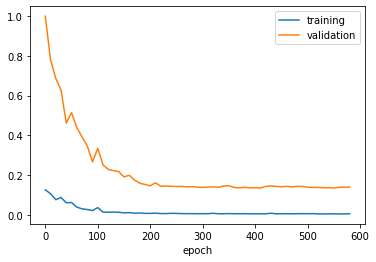

In [11]:
# plot loss history
losses = np.array(loss_history)
n = losses.shape[0]-1
plt.plot(np.arange(n)*10, losses[1:,0], label='training')
plt.plot(np.arange(n)*10, losses[1:,1], label='validation')
plt.xlabel('epoch')
plt.legend()

# Test reconstruction of training data
The model should (over)fit on training data. Output coordinates should match input

max_length= 363
(83, 360, 7) (83, 360, 2)
torch.Size([1, 360, 2])
torch.Size([1, 360, 5])


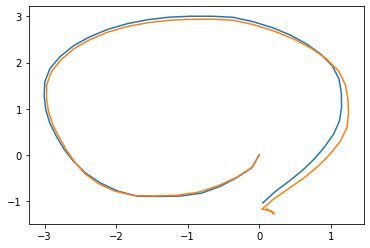

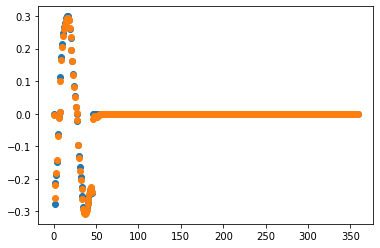

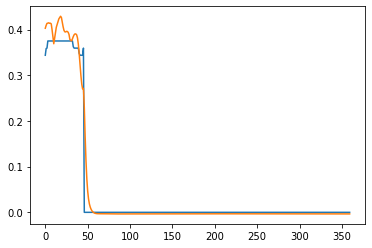

In [13]:
# test

strokes = load_strokes(cyn_file)
stroke_points = convert_strokes_to_points(strokes)

# format:
# 0 delta x
# 1 delta y
# 2 pressure
# 3 rotation
# 4 tilt X
# 5 tilt Y
# 6 x0
# 7 y0
stroke_8d = np.array(normalize_strokes(stroke_points, seq_length))
stroke_xy = stroke_8d[:, :, :2]
print(stroke_8d.shape, stroke_xy.shape)

sample_idx = 6
inputs = torch.FloatTensor(stroke_xy[sample_idx]).cuda().unsqueeze(0)#.permute(0,2,1) 
print(inputs.size())
outputs = model.generate(inputs)
print(outputs.size())

outputs = outputs.squeeze().detach().cpu().numpy()
inputs = inputs.squeeze().detach().cpu().numpy()


plt.figure()
plt.plot(np.cumsum(inputs[:,0]), np.cumsum(inputs[:,1])) # summation of dx,dy
plt.plot(np.cumsum(outputs[:,0]), np.cumsum(outputs[:,1]))

plt.figure()
idx = 1
plt.scatter(list(range(inputs.shape[0])), inputs[:,idx]) # time series
plt.scatter(list(range(outputs.shape[0])), outputs[:,idx])

plt.figure()
idx = 1
plt.plot(stroke_8d[sample_idx,:,2+idx])
plt.plot(outputs[:,2+idx])

# Generate drawings with query
Queried with a 2-d drawing (only x,y coordinates), the model should "hallucinate" a drawing with 5-d stroke points - with pressure, tilt x/y

The following code outputs cyn data and will be saved to disk to be further visualized using external software

In [14]:
def generate_with_query(cynfile, result_path):
  delta_scale = 100
  strokes = load_strokes(cynfile)
  stroke_points = convert_strokes_to_points(strokes)
  stroke_7d = np.array(normalize_strokes(stroke_points, seq_length))
  print(stroke_7d.shape)
  stroke_xy = stroke_7d[:, :, :2]
  n_samples = stroke_xy.shape[0]
  result = []
  initial_stroke = True
  set_initial_stroke = False
  for i in range(n_samples):
    original_stroke = stroke_7d[i]
    inputs = torch.FloatTensor(stroke_xy[i]).cuda().unsqueeze(0)
    outputs = model.generate(inputs)
    outputs = outputs.squeeze().detach().cpu().numpy()

    xs = np.cumsum(original_stroke[:,0]) / delta_scale
    ys = np.cumsum(original_stroke[:,1]) / delta_scale 
    if initial_stroke:
      x0 = stroke_7d[i,0,-2]
      y0 = stroke_7d[i,0,-1]
    xs = x0 + xs
    ys = y0 + ys
w
      if original_stroke[j,0] == original_stroke[j,1] == original_stroke[j,2] == original_stroke[j,3] \
        == original_stroke[j,4] == original_stroke[j,5] == original_stroke[j,6] == 0:
        set_initial_stroke = True # next time
        break
      points.append([j, 0.02*j, xs[j], ys[j], outputs[j,2], 0, outputs[j,3], outputs[j,4]])
      set_initial_stroke = False

    initial_stroke = set_initial_stroke
    x0 = points[-1][2]
    y0 = points[-1][3]
    result.append(points.copy())
  
  # merge
  new_result = []
  last_stroke = []
  for stroke in result:
    last_stroke += stroke
    print(len(stroke))
    if len(stroke) < seq_length:
      new_result.append(last_stroke.copy())
      last_stroke = []

  for stroke in new_result:
    for i in range(len(stroke)):
      stroke[i][0] = i

  result = new_result

  # write to new cyn file
  with open(result_path, 'w') as f:
    f.write('#\nVersion 0.0\n#\n\nphotoshop 5\n1\nunrelated\n\n')
    f.write(str(len(result)) + '\n')
    index = 0
    for stroke in result:
      f.write("stroke "+str(index)+"\n")
      f.write(str(len(stroke))+"\n")
      for points in stroke:
        f.write(" ".join([str(i) for i in points]) + "\n")
      f.write("\n")
      index += 1

  print(result)

generate_with_query("../original_cyn_data/BrendaFlower.cyn", "../results/BrendaFlowerGenerated.cyn")

max_length= 542
(40, 360, 7)
157
50
133
140
144
35
11
56
36
34
28
28
43
10
47
69
68
36
147
26
86
78
58
152
69
82
57
71
14
20
360
360
46
30
26
194
28
21
58
11
[[[0, 0.0, 0.437301, 0.245063, 0.11626023, 0, 0.402883, -0.23297954], [1, 0.02, 0.438637, 0.247595, 0.3284998, 0, 0.4172207, -0.19137546], [2, 0.04, 0.4396, 0.250397, 0.38999408, 0, 0.4327445, -0.2046333], [3, 0.06, 0.440165, 0.253342, 0.41557425, 0, 0.4287387, -0.22183019], [4, 0.08, 0.440458, 0.256327, 0.42969102, 0, 0.42305, -0.23488134], [5, 0.1, 0.440703, 0.259313, 0.4397655, 0, 0.41789925, -0.2406829], [6, 0.12, 0.440797, 0.26231, 0.43852192, 0, 0.41143847, -0.23420513], [7, 0.14, 0.440919, 0.265307, 0.4400112, 0, 0.40764374, -0.2264744], [8, 0.16, 0.441082, 0.2683, 0.44317824, 0, 0.40490556, -0.21878749], [9, 0.18, 0.441129, 0.2713, 0.44266695, 0, 0.4011302, -0.21087608], [10, 0.2, 0.441129, 0.2743, 0.4434871, 0, 0.39909244, -0.20387268], [11, 0.22, 0.441129, 0.2773, 0.4465726, 0, 0.39848983, -0.1976425], [12, 0.24, 0.44112

max_length= 542
(40, 360, 7) (40, 360, 2)
torch.Size([1, 360, 2])
torch.Size([1, 360, 5])


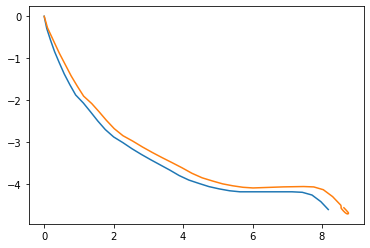

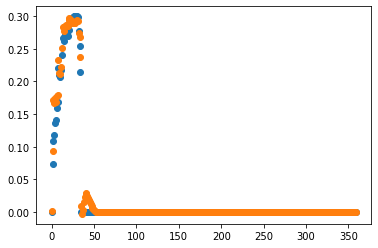

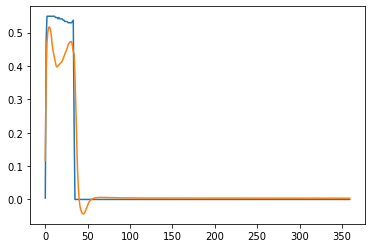

In [15]:
# test with different dataset

strokes = load_strokes("../original_cyn_data/BrendaFlower.cyn")
stroke_points = convert_strokes_to_points(strokes)

# format:
# 0 delta x
# 1 delta y
# 2 pressure
# 3 rotation
# 4 tilt X
# 5 tilt Y
# 6 x0
# 7 y0
stroke_8d = np.array(normalize_strokes(stroke_points, seq_length))
stroke_xy = stroke_8d[:, :, :2]
print(stroke_8d.shape, stroke_xy.shape)

sample_idx = 5
inputs = torch.FloatTensor(stroke_xy[sample_idx]).cuda().unsqueeze(0)#.permute(0,2,1) 
print(inputs.size())
outputs = model.generate(inputs)
print(outputs.size())

outputs = outputs.squeeze().detach().cpu().numpy()
inputs = inputs.squeeze().detach().cpu().numpy()


plt.figure()
plt.plot(np.cumsum(inputs[:,0]), np.cumsum(inputs[:,1])) # summation of dx,dy
plt.plot(np.cumsum(outputs[:,0]), np.cumsum(outputs[:,1]))

plt.figure()
plt.scatter(list(range(inputs.shape[0])), inputs[:,0]) # time series
plt.scatter(list(range(outputs.shape[0])), outputs[:,0])

plt.figure()
idx = 0
plt.plot(stroke_8d[sample_idx,:,2+idx])
plt.plot(outputs[:,2+idx])

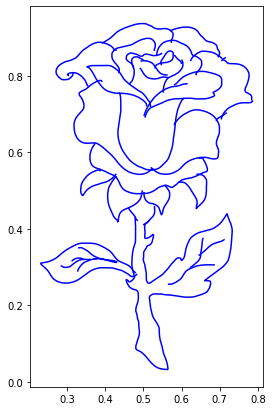

In [10]:
# draw original sketch
strokes = load_strokes("../original_cyn_data/BrendaFlower.cyn")
stroke_points = convert_strokes_to_points(strokes)

plt.figure(figsize=(7,7))
for stroke in stroke_points:
  arr = np.array(stroke)
  plt.plot(arr[:,2], 1.0-arr[:,3], c='b')
plt.gca().set_aspect('equal', adjustable='box')